In [3]:
import pandas as pd
import numpy as np
T = 1
nsteps = 48
files = [
    f'../data/export/test/zerobond_results_T/zerobond_1_normalize_True_test_results_sigma_0.01_dim_1_{t}_5000_{t * nsteps}_epochs_1500.csv'
    for t in [1, 2, 4, 5, 6, 7, 8]
]
df_0 = pd.read_csv(
    files[0]
)

In [76]:
import tensorflow as tf
from utils.utils.utils import (
    ZeroBond
)
from utils.utils.utils import (
    FinanceUtils
)

delta_x = df_0._delta_x.values
xt = df_0.xt.values
dt = df_0.dt.values
ct = FinanceUtils.C(
    T, 
    sigma_value = 0.01
)
nt = ZeroBond.N_tensor(
    dt,
    xt,
    ct
)
# Convert to tensors
xt = tf.convert_to_tensor(
    xt, 
    dtype = tf.float64
)
delta_x = tf.convert_to_tensor(
    delta_x,
    dtype = tf.float64
)
dt = tf.convert_to_tensor(
    dt, 
    dtype = tf.float64
)
ct = tf.Variable(
    np.float64(ct), 
    name = 'ct', 
    trainable=False
)
T = tf.Variable(
    np.float64(T), 
    name = 'T', 
    trainable=False
)

In [77]:
h = 1e-5
y = ZeroBond.Z_tensor(
    xt, 
    dt, 
    T, 
    ct
)
y_h = ZeroBond.Z_tensor(
    xt + h, 
    dt, 
    T, 
    ct
)
grads_hand = (y_h - y) / h

In [86]:
xt = tf.Variable(xt, name = 'xn', trainable = True)
dt = tf.Variable(dt, name = 'tn', trainable = True)
ct = tf.Variable(np.float64(ct), name = 'ct', trainable=False)
with tf.GradientTape() as tape:
    y = ZeroBond.Z_tensor(
        xt, 
        dt, 
        T, 
        ct
    )
grad_df = tape.gradient(y, {
    'xn':xt,
    'tn': dt
})
grads = grad_df['xn']
grads_dt = grad_df['tn']

In [79]:
# Masks for prediction
idx_preds = np.array(range(0, xt.shape[0], nsteps))
np_mask_v = np.ones((xt.shape[0], 1))
np_mask_v[idx_preds] = 0
mask_v = tf.convert_to_tensor(
    np_mask_v, 
    dtype = tf.float64
)
mask_preds = tf.abs(
    tf.convert_to_tensor(
        np_mask_v,
        dtype = tf.float64
    ) - 1)

In [87]:
# Tensor operations
batch_size = int(
    xt.shape[0] / nsteps
)
grads_reshaped = tf.reshape(grads, (batch_size, nsteps))
grads_dt_reshaped = tf.reshape(grads_dt, (batch_size, nsteps))
xt_reshaped = tf.reshape(xt, (batch_size, nsteps))
delta_x_reshaped = tf.reshape(delta_x, (batch_size, nsteps))
# Calculate the MVP
v = np.ones((batch_size, nsteps)) * 0.97039797
for i in range(1, nsteps):
    v[:, i] = (v[:, i - 1] + grads_reshaped[:, i] * delta_x_reshaped[:, i]) + grads_dt_reshaped[:, i] * T/nsteps

In [88]:
v_real = ZeroBond.Z_tensor(
    xt, 
    dt, 
    T, 
    ct
)
v_real_reshaped = tf.reshape(
    v_real,
    (
        batch_size,
        nsteps
    )
)

In [104]:
v_real = np.array(
    tf.reshape(v_real_reshaped[0, :], -1)
)
v_column = np.array(
    tf.reshape(v[0, :], -1)
)
dt_list = np.array(
    dt
)
df_results = pd.DataFrame(
    zip(
        v_real, 
        v_column, 
        dt_list
    ), 
    columns = [
        "v_real",
        "v_est",
        "dt"
    ]
)

In [105]:
df_results.head()

,v_real,v_est,dt
0,0.970398,0.970398,0.000000
1,0.969160,0.969300,0.090909
2,0.968668,0.968917,0.181818
3,0.972415,0.972348,0.272727
4,0.976865,0.976386,0.363636


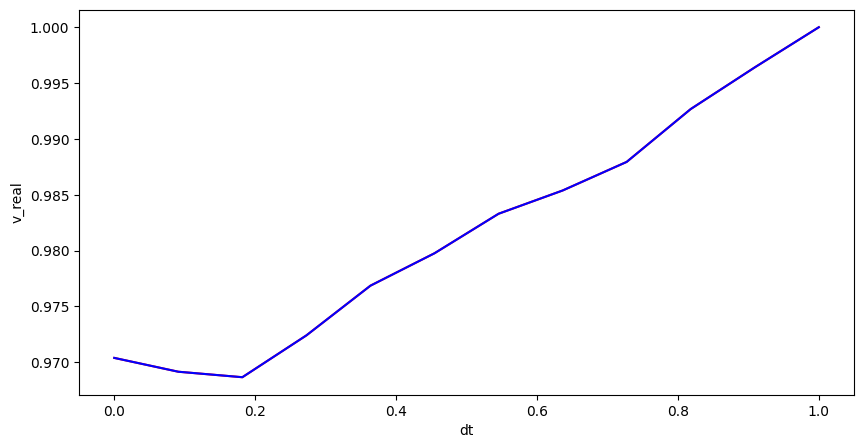

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(
    figsize = (
        10,
        5
    )
)
sns.lineplot(
    x = 'dt',
    y = 'v_real',
    data = df_results,
    color = 'red'
)
sns.lineplot(
    x = 'dt',
    y = 'v_real',
    data = df_results,
    color = 'blue'
)
plt.show()